In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import os
import pysam

In [4]:
# Sample titles with corresponding barcodes
samples = {
    's9': ['ATCACG', 'ACAGTG'],
    's9+bcm': ['CGATGT', 'GCCAAT'],
    's17': ['TTAGGC', 'GATCAG'],
    's17+bcm': ['TGACCA', 'TAGCTT'],
    's19': ['CAGATC','GGCTAC'],
    's19+bcm': ['ACTTGA', 'CTTGTA']
}

# Barcodes
barcodes = ['ATCACG', 'ACAGTG', 'CGATGT', 'GCCAAT', 'TTAGGC', 'GATCAG',
            'TGACCA', 'TAGCTT', 'CAGATC','GGCTAC', 'ACTTGA', 'CTTGTA']


In [6]:
%%writefile ../utils/get_utr_array.py
def get_utr_array(df, barcodes, reference, res_dir='../../results'):
    
    def get_coverage_vector(rec):
        utr = np.zeros(shape=(max_length,), dtype=np.int16)
        start,end = rec['start'], rec['end']
        if start > end:
            start,end = end,start

        pileup = bamfile.pileup(reference, start, start+max_length,
                                max_depth=1e9,
                                truncate=True)
        for p in pileup:
            offset = abs(p.pos-start)
            utr[offset] = p.n
        return utr
    
    def get_coverage_vector1(rec):
        utr = np.zeros(shape=(max_length,), dtype=np.int16)
        start,end = rec['start'], rec['end']
        if start > end:
            start,end = end,start

        pileup = bamfile.pileup(reference, start, end,
                                max_depth=1e9, truncate=True)
        for i,col in enumerate(pileup):
            # I don't know why
            try:
                utr[i] = col.n
            except IndexError:
                pass
            utr_lengths.append(i)
        return utr

    result = []
    d, _, filenames = next(os.walk(res_dir))
    infiles = [f for f in filenames if f.endswith('_sorted.bam')]
    for barcode in barcodes:
        filename = os.path.join(d, [f for f in infiles if barcode in f][0])
        data = np.zeros(shape=(num_utrs, max_length), dtype=np.int16)
        bamfile = pysam.AlignmentFile(filename, 'rb')
        for (i, row) in df.iterrows():
            data[i] = get_coverage_vector(row)
        result.append(data)
    return result


Writing ../utils/get_utr_array.py


In [5]:
# 5' UTR annotations
res = []
with open('../../results/redux/utrs_corr.bed', 'r') as fi:
    for line in fi:
        fields = line.strip().split()
        res.append({
                'gene': fields[3],
                'start': int(fields[1]),
                'end': int(fields[2]),
            })
 
df_utr5 = pd.DataFrame.from_records(res)
df_utr5['UTR_length'] = abs(df_utr5['end'] - df_utr5['start'])
df_utr5 = df_utr5[df_utr5['UTR_length'] > 80]

max_length = df_utr5['UTR_length'].max() + 1
num_utrs = df_utr5.shape[0]

In [7]:
utrs = df_utr5.reset_index(drop=True)
data = get_utr_array(utrs, ['ATCACG'], 'gi|556503834|ref|NC_000913.3|')
data1 = get_utr_array(utrs, ['ACAGTG'], 'gi|556503834|ref|NC_000913.3|')
data_bcm = get_utr_array(utrs, ['GCCAAT'], 'gi|556503834|ref|NC_000913.3|')
data_bcm1 = get_utr_array(utrs, ['CGATGT'], 'gi|556503834|ref|NC_000913.3|')

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
import math

In [8]:
%%writefile ../utils/plot_utr_heatmap.py
def plot_utr_heatmap(data, cmap=cm.OrRd, ylim=[1750, 1500], orientation='vertical'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    utr = data[0].copy()
    utr[utr<0] = 0
    utr.sort(axis=0)
    max_val = np.max(utr)
    midpoint = math.ceil(max_val / 2)
    fig, ax = plt.subplots(figsize=(18,18))
    im = ax.imshow(utr,cmap=cmap)
    ax.set_title("Read depth at 5'UTR", fontsize=20)
    ax.set_ylim(ylim)
    ax.set_xlabel('Position from TSS', fontsize=20)
    ax.get_yaxis().set_ticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, ticks=[0,midpoint,max_val], orientation=orientation)
    cbar.ax.invert_yaxis()
    cbar.ax.set_xticklabels(['0', '{0}'.format(int(midpoint)), '{0}'.format(int(max_val))], fontsize=20)
    plt.show()

Writing ../utils/plot_utr_heatmap.py


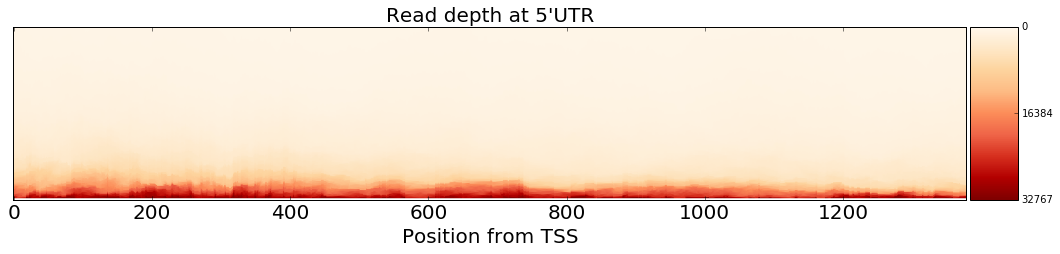

In [10]:
plot_utr_heatmap(data)

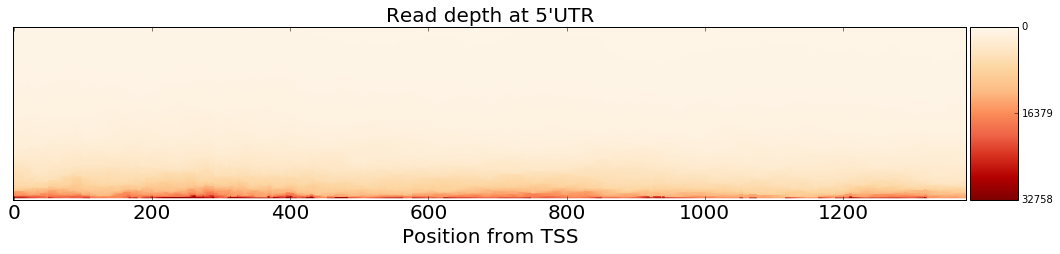

In [11]:
plot_utr_heatmap(data_bcm)

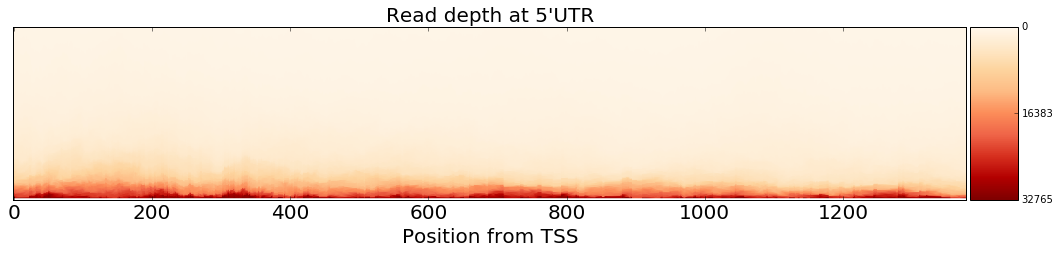

In [12]:
plot_utr_heatmap(data1)

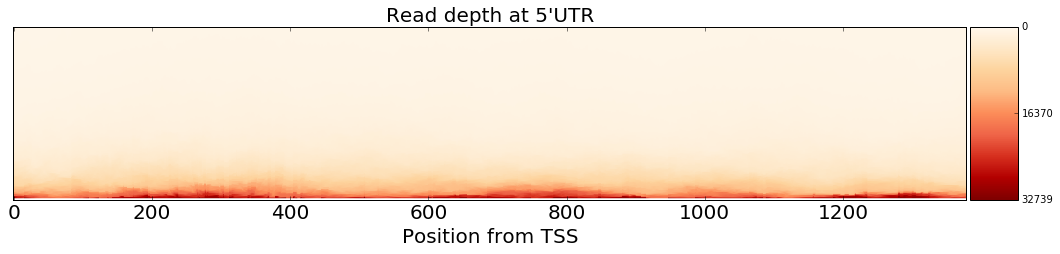

In [13]:
plot_utr_heatmap(data_bcm1)

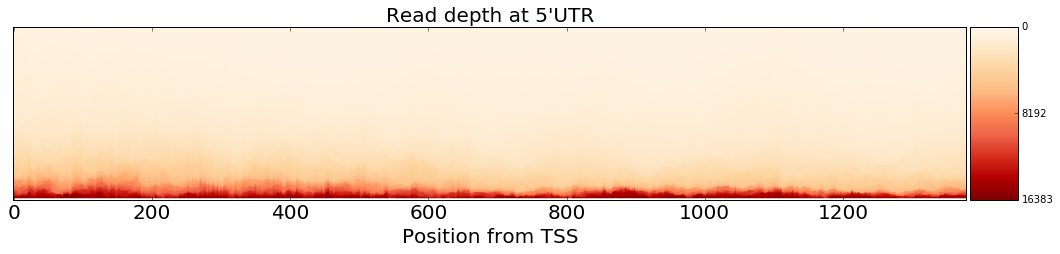

In [14]:
plot_utr_heatmap([(data[0] + data1[0]) / 2.])

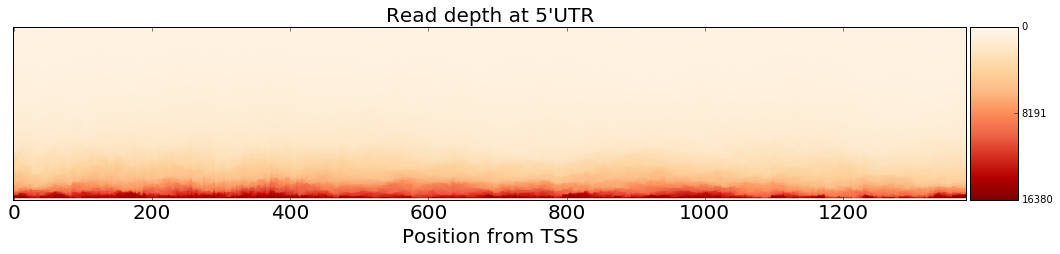

In [15]:
plot_utr_heatmap([(data_bcm[0] + data_bcm1[0]) / 2.])

In [16]:
np.savetxt('../../results/redux/ATCACG.UTR_heatmap_long.txt.gz', data[0], delimiter='\t')
np.savetxt('../../results/redux/ACAGTG.UTR_heatmap_long.txt.gz', data1[0], delimiter='\t')
np.savetxt('../../results/redux/GCCAAT.UTR_heatmap_long.txt.gz', data_bcm[0], delimiter='\t')
np.savetxt('../../results/redux/CGATGT.UTR_heatmap_long.txt.gz', data_bcm1[0], delimiter='\t')

In [17]:
data_tpl = '../../results/redux/{0}.UTR_heatmap_long.txt.gz'
data = {}

for barcode in barcodes:
    try:
        data[barcode] = np.loadtxt(data_tpl.format(barcode), delimiter='\t')
    except IOError:
        pass

In [18]:
data

{'ACAGTG': array([[  404.,   399.,   400., ...,   352.,   352.,   351.],
        [  237.,   231.,   229., ...,    11.,    11.,    15.],
        [  237.,   231.,   229., ...,    11.,    11.,    15.],
        ..., 
        [ 1416.,  1419.,  1425., ...,     0.,     0.,     0.],
        [ 1416.,  1419.,  1425., ...,     0.,     0.,     0.],
        [   49.,    50.,    49., ...,     0.,     0.,     0.]]),
 'ATCACG': array([[  224.,   220.,   220., ...,   273.,   272.,   269.],
        [  171.,   169.,   162., ...,     9.,     9.,     9.],
        [  171.,   169.,   162., ...,     9.,     9.,     9.],
        ..., 
        [ 1573.,  1573.,  1572., ...,     0.,     0.,     0.],
        [ 1573.,  1573.,  1572., ...,     0.,     0.,     0.],
        [   60.,    60.,    61., ...,     0.,     0.,     0.]]),
 'CGATGT': array([[ 176.,  171.,  172., ...,  124.,  123.,  122.],
        [  83.,   79.,   77., ...,   40.,   41.,   41.],
        [  83.,   79.,   77., ...,   40.,   41.,   41.],
        ...

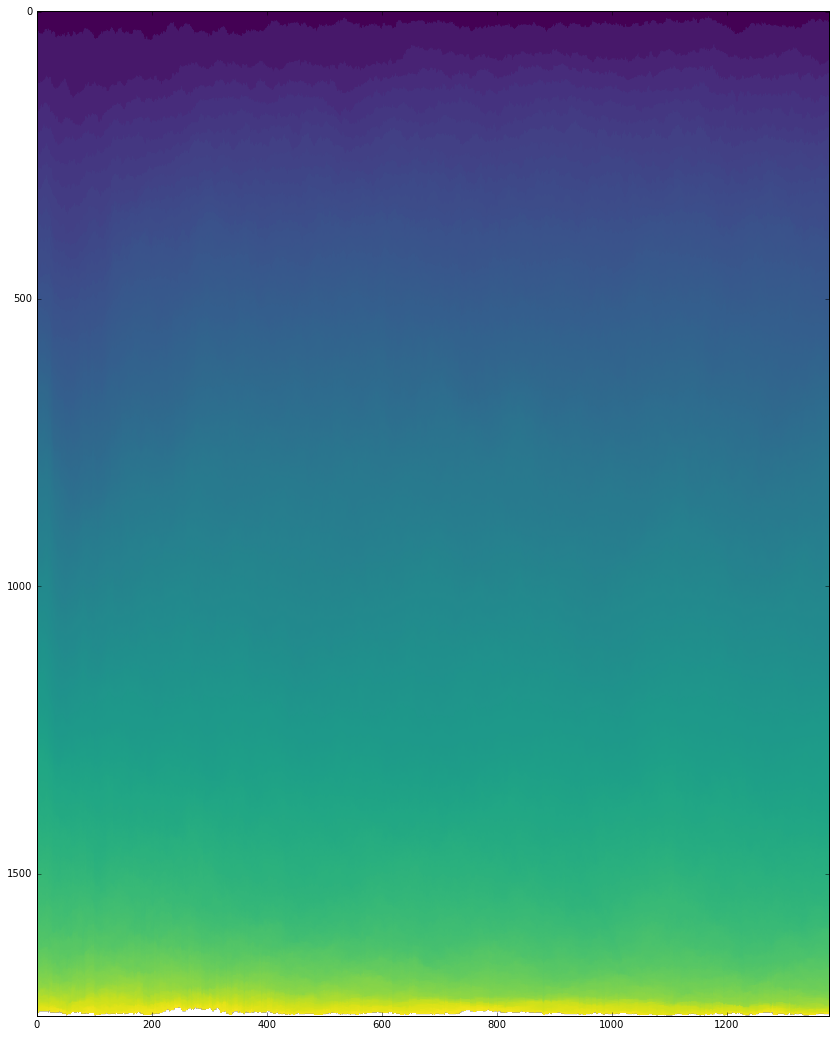

In [19]:
fig, ax = plt.subplots(figsize=(18,18))

d = (data['ACAGTG'] + data['ATCACG']) / 2.
d[d==0] = 1
d = np.log2(d)
d.sort(axis=0)
im = ax.imshow(d, cmap=cm.viridis)
plt.show()

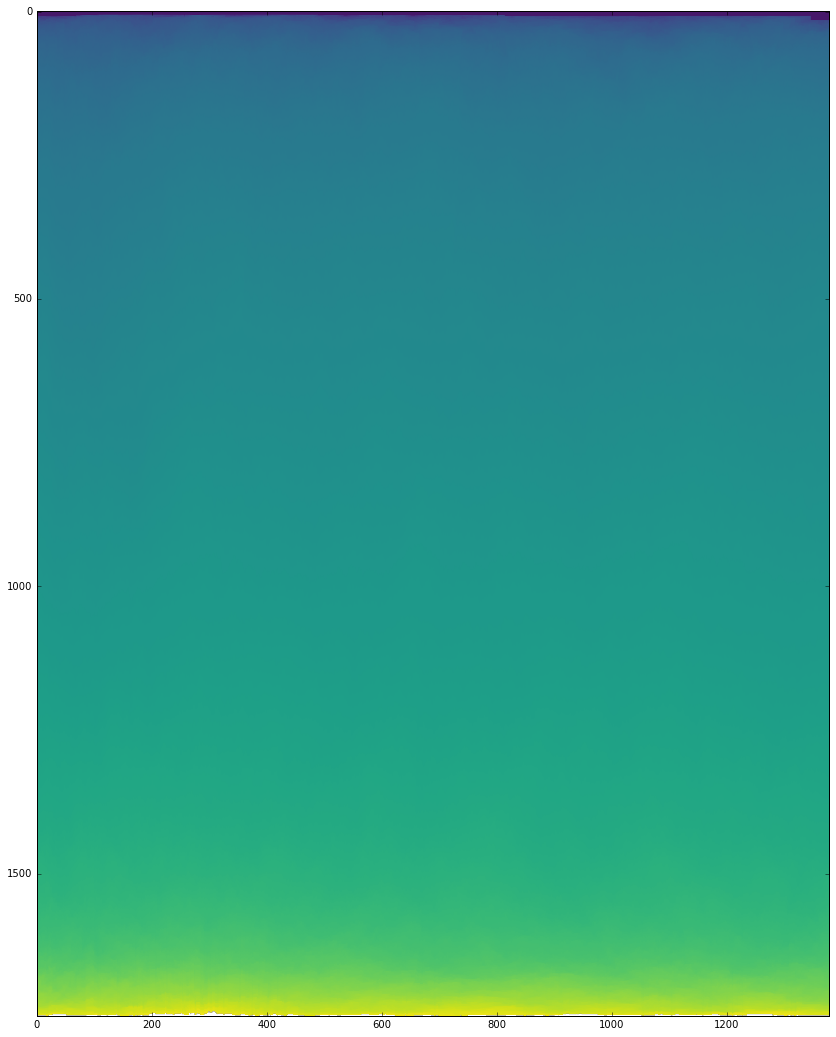

In [20]:
fig, ax = plt.subplots(figsize=(18,18))

d = (data['CGATGT'] + data['GCCAAT']) / 2.
d[d==0] = 1
d = np.log2(d)
d.sort(axis=0)
im = ax.imshow(d, cmap=cm.viridis)
plt.show()

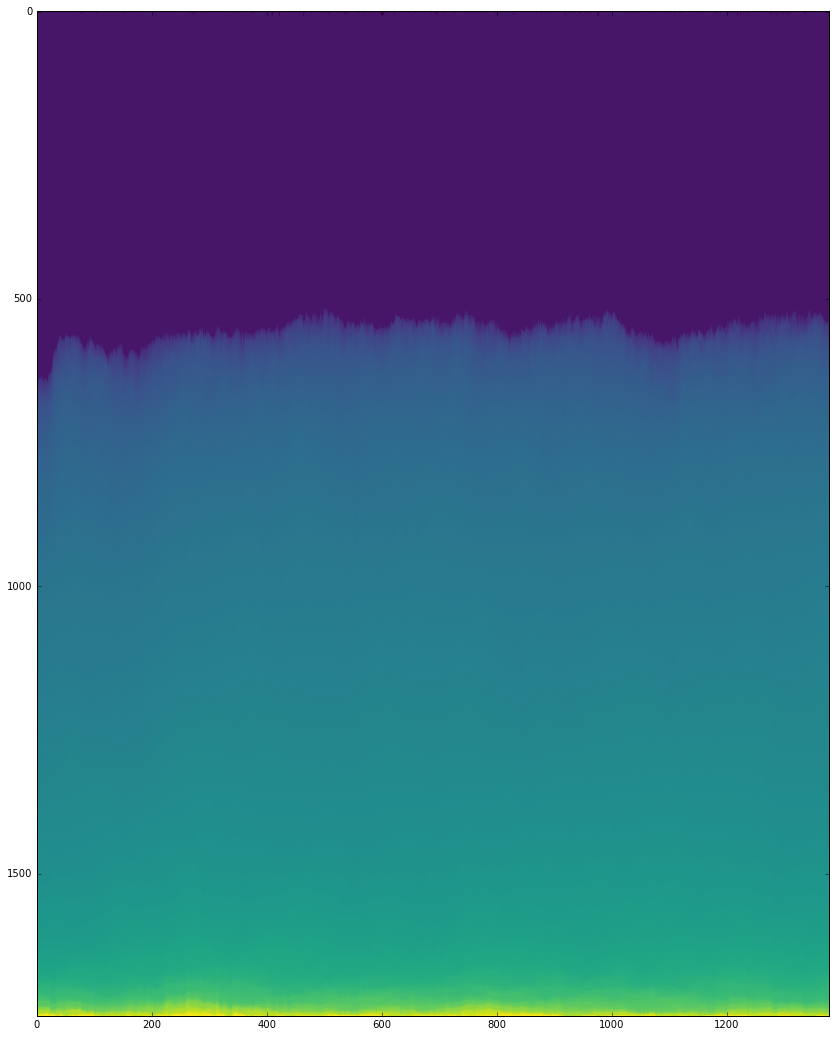

In [21]:
fig, ax = plt.subplots(figsize=(18,18))

d1 = (data['CGATGT'] + data['GCCAAT']) / 2.
d2 = (data['ACAGTG'] + data['ATCACG']) / 2.
d = d1 - d2
d[d<=0] = 1
d = np.log2(d)
d.sort(axis=0)
im = ax.imshow(d, cmap=cm.viridis)
plt.show()

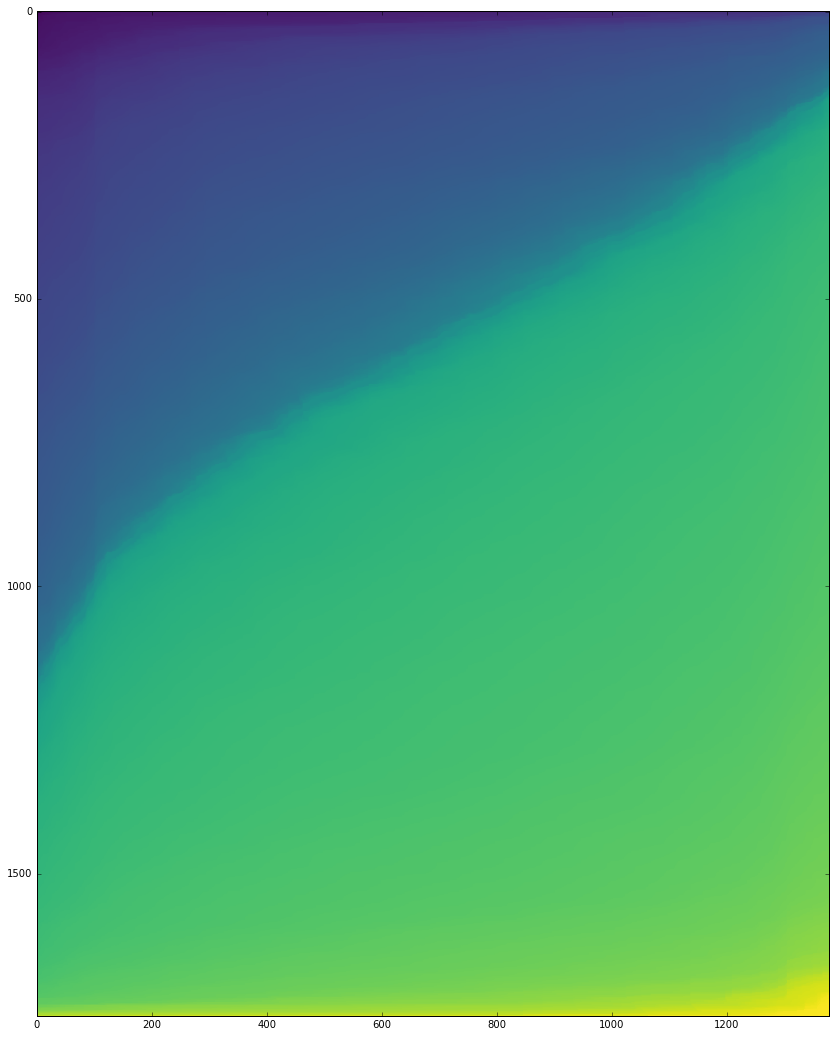

In [27]:
norm_factors = {
    'ATCACG': 26.237008,
    'CGATGT': 24.797240,
    'TTAGGC': 21.702670,
    'TGACCA': 23.725833,
    'CAGATC': 24.297996,
    'ACTTGA': 28.749629,
    'ACAGTG': 25.350698,
    'GCCAAT': 21.722852,
    'GATCAG': 27.832386,
    'TAGCTT': 27.386291,
    'GGCTAC': 25.960868,
    'CTTGTA': 29.292834,
}

fig, ax = plt.subplots(figsize=(18,18))

ndata = {}
for barcode,factor in norm_factors.items():
    try:
        ndata[barcode] = data[barcode] * norm_factors[barcode] / norm_factors['CTTGTA']
    except KeyError:
        pass
    
d1 = (ndata['CGATGT'] + ndata['GCCAAT']) / 2.
d2 = (ndata['ACAGTG'] + ndata['ATCACG']) / 2.
d = d1 - d2
d[d==0] = 1
d[d>0] = np.log2(d[d>0])
d[d<0] = -1 * np.log2(-1 * d[d<0])
d.sort(axis=1)
d.sort(axis=0)

im = ax.imshow(d, cmap=cm.viridis)
plt.show()

In [9]:
%%writefile ../utils/plot_heatmap.py
def plot_utr_heatmap(data, title=None, cmap=cm.OrRd, orientation='vertical'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    utr = data.copy()
    max_val = np.max(utr)
    min_val = np.min(utr)
    midpoint = (max_val + min_val) / 2
    fig, ax = plt.subplots(figsize=(18,18))
    im = ax.imshow(utr,cmap=cmap)
    if title:
        ax.set_title(title, fontsize=20)
    else:
        ax.set_title("Read depth at 5'UTR", fontsize=20)
    ax.set_xlabel('Position from TSS', fontsize=20)
    ax.get_yaxis().set_ticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, ticks=[min_val,0,max_val], orientation=orientation)
    cbar.ax.invert_yaxis()
    cbar.ax.tick_params(labelsize=20)
    #cbar.ax.set_xticklabels(['0', '{0}'.format(int(midpoint)), '{0}'.format(int(max_val))], fontsize=20)
    plt.show()

Writing ../utils/plot_heatmap.py


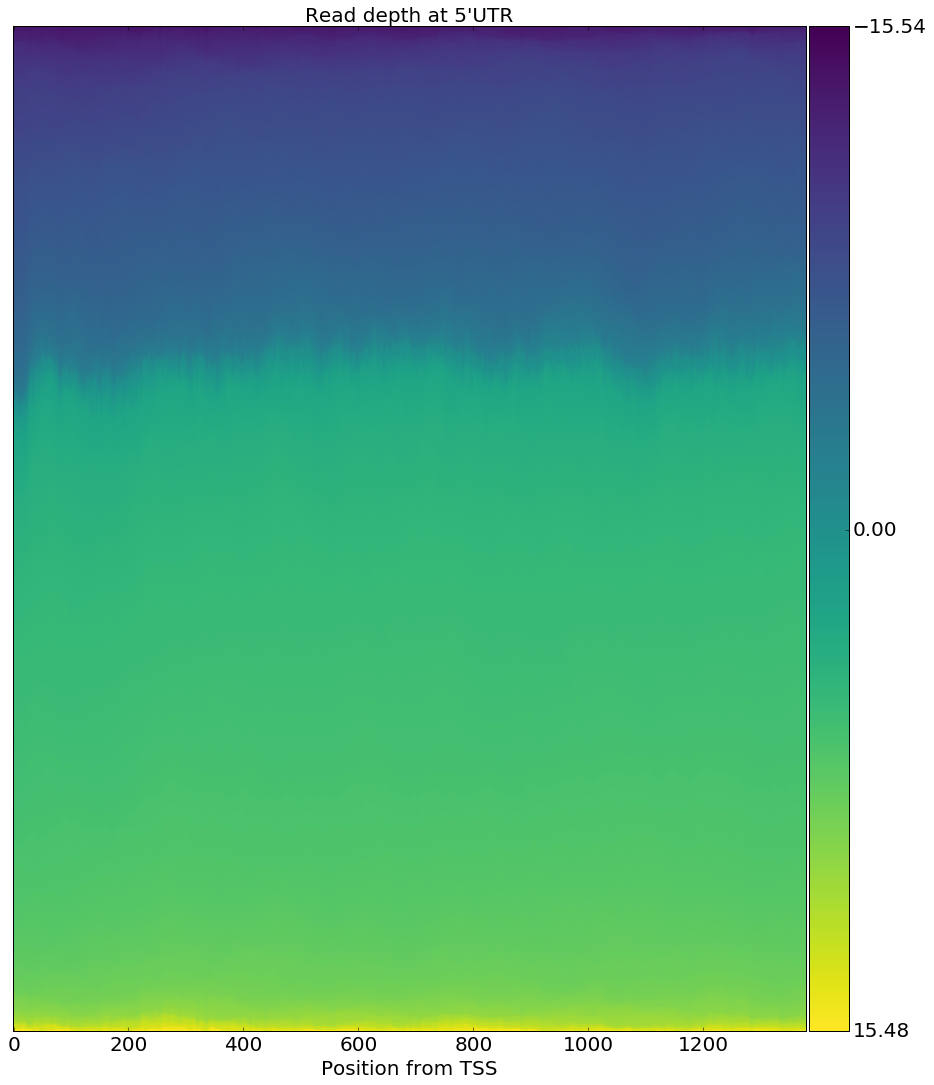

In [24]:
plot_utr_heatmap(d, cmap=cm.viridis)

In [31]:
np.max(data['ACAGTG'])

8089.0

In [35]:
dt= get_utr_array(utrs, ['ATCACG'], 'gi|556503834|ref|NC_000913.3|')
dt1 = get_utr_array(utrs, ['ACAGTG'], 'gi|556503834|ref|NC_000913.3|')
dt_bcm = get_utr_array(utrs, ['GCCAAT'], 'gi|556503834|ref|NC_000913.3|')
dt_bcm1 = get_utr_array(utrs, ['CGATGT'], 'gi|556503834|ref|NC_000913.3|')

In [36]:
np.savetxt('../../results/redux/ATCACG.UTR_heatmap_nomax.txt.gz', dt[0], delimiter='\t')
np.savetxt('../../results/redux/ACAGTG.UTR_heatmap_nomax.txt.gz', dt1[0], delimiter='\t')
np.savetxt('../../results/redux/GCCAAT.UTR_heatmap_nomax.txt.gz', dt_bcm[0], delimiter='\t')
np.savetxt('../../results/redux/CGATGT.UTR_heatmap_nomax.txt.gz', dt_bcm1[0], delimiter='\t')

In [37]:
data_tpl = '../../results/redux/{0}.UTR_heatmap_nomax.txt.gz'
data = {}

for barcode in barcodes:
    try:
        data[barcode] = np.loadtxt(data_tpl.format(barcode), delimiter='\t')
    except IOError:
        pass

In [39]:
ndata = {}
for barcode,factor in norm_factors.items():
    try:
        ndata[barcode] = data[barcode] * norm_factors[barcode] / norm_factors['CTTGTA']
    except KeyError:
        pass
    
d1 = (ndata['CGATGT'] + ndata['GCCAAT']) / 2.
d2 = (ndata['ACAGTG'] + ndata['ATCACG']) / 2.
d = d1 - d2
d[d==0] = 1
d[d>0] = np.log2(d[d>0])
d[d<0] = -1 * np.log2(-1 * d[d<0])
d.sort(axis=0)


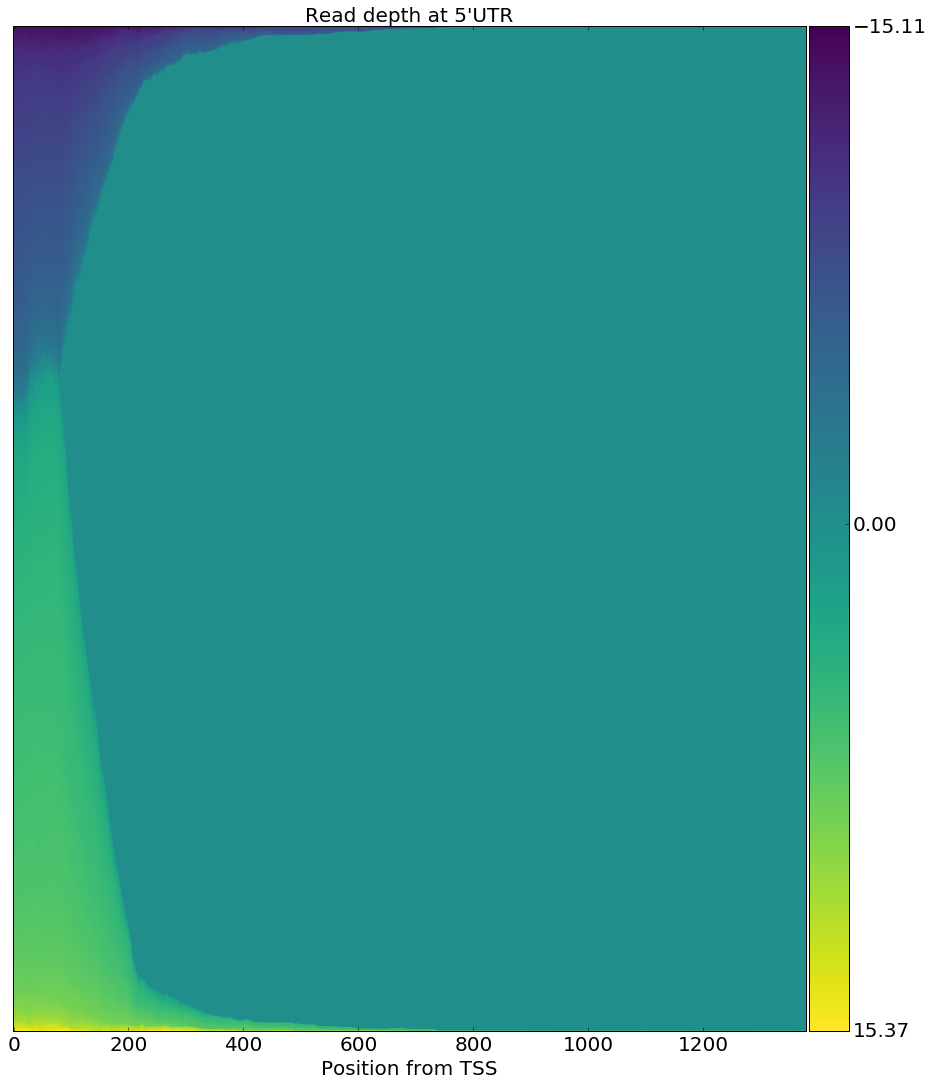

In [40]:
plot_utr_heatmap(d, cmap=cm.viridis)

In [41]:
import pybedtools

In [55]:
u = pybedtools.BedTool('../../results/redux/utrs.fixed.bed')

In [47]:
%%bash

echo -e "gi|556503834|ref|NC_000913.3|\t4641652" > ../../ref/MG1655.chro

In [58]:
reference = 'gi|556503834|ref|NC_000913.3|'
with open('../../results/redux/utrs_corr.bed', 'r') as fi, open('../../results/redux/utrs.fixed.bed', 'w') as fo:
    for line in fi:
        fields = line.strip().split()
        start, end = int(fields[1]), int(fields[2])
        if start > end:
            start, end = end, start
        fo.write('{ref}\t{start}\t{end}\t{gene}\n'.format(
            ref=reference,
            start=start,
            end=end,
            gene=fields[3]))

In [59]:
v = u.shuffle(g='../../ref/MG1655.chro')
v

<BedTool(/tmp/pybedtools.rswsfgzj.tmp)>

In [60]:
v.saveas("../../results/redux/utrs.random.bed")

<BedTool(../../results/redux/utrs.random.bed)>

In [61]:
# For control: randomly shuffle UTRs over genome

# 5' UTR annotations
res = []
with open('../../results/redux/utrs.random.bed', 'r') as fi:
    for line in fi:
        fields = line.strip().split()
        res.append({
                'gene': fields[3],
                'start': int(fields[1]),
                'end': int(fields[2]),
            })
 
df_utr5 = pd.DataFrame.from_records(res)
df_utr5['UTR_length'] = abs(df_utr5['end'] - df_utr5['start'])
df_utr5 = df_utr5[df_utr5['UTR_length'] > 80]

max_length = df_utr5['UTR_length'].max() + 1
num_utrs = df_utr5.shape[0]

In [62]:
utrs = df_utr5.reset_index(drop=True)
data = get_utr_array(utrs, ['ATCACG'], 'gi|556503834|ref|NC_000913.3|')
data1 = get_utr_array(utrs, ['ACAGTG'], 'gi|556503834|ref|NC_000913.3|')
data_bcm = get_utr_array(utrs, ['GCCAAT'], 'gi|556503834|ref|NC_000913.3|')
data_bcm1 = get_utr_array(utrs, ['CGATGT'], 'gi|556503834|ref|NC_000913.3|')

In [63]:
np.savetxt('../../results/redux/ATCACG.UTR_heatmap_random.txt.gz', data[0], delimiter='\t')
np.savetxt('../../results/redux/ACAGTG.UTR_heatmap_random.txt.gz', data1[0], delimiter='\t')
np.savetxt('../../results/redux/GCCAAT.UTR_heatmap_random.txt.gz', data_bcm[0], delimiter='\t')
np.savetxt('../../results/redux/CGATGT.UTR_heatmap_random.txt.gz', data_bcm1[0], delimiter='\t')

In [69]:
data_tpl = '../../results/redux/{0}.UTR_heatmap_random.txt.gz'
data = {}

for barcode in barcodes:
    try:
        data[barcode] = np.loadtxt(data_tpl.format(barcode), delimiter='\t')
    except IOError:
        pass

In [70]:
data

{'ACAGTG': array([[ 226.,  226.,  222., ...,    0.,    0.,    0.],
        [ 122.,  122.,  120., ...,    0.,    0.,    0.],
        [  13.,   13.,   10., ...,    0.,    0.,    0.],
        ..., 
        [   8.,    7.,    7., ...,    0.,    0.,    0.],
        [  14.,   14.,   17., ...,    0.,    0.,    0.],
        [   5.,    5.,    5., ...,    0.,    0.,    0.]]),
 'ATCACG': array([[ 394.,  403.,  406., ...,    0.,    0.,    0.],
        [ 122.,  123.,  122., ...,    0.,    0.,    0.],
        [   4.,    4.,    4., ...,    0.,    0.,    0.],
        ..., 
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [  19.,   20.,   20., ...,    0.,    0.,    0.],
        [   1.,    1.,    1., ...,    0.,    0.,    0.]]),
 'CGATGT': array([[ 193.,  186.,  185., ...,    0.,    0.,    0.],
        [  76.,   72.,   72., ...,    0.,    0.,    0.],
        [  36.,   34.,   31., ...,    0.,    0.,    0.],
        ..., 
        [ 143.,  141.,  143., ...,    0.,    0.,    0.],
        [  5

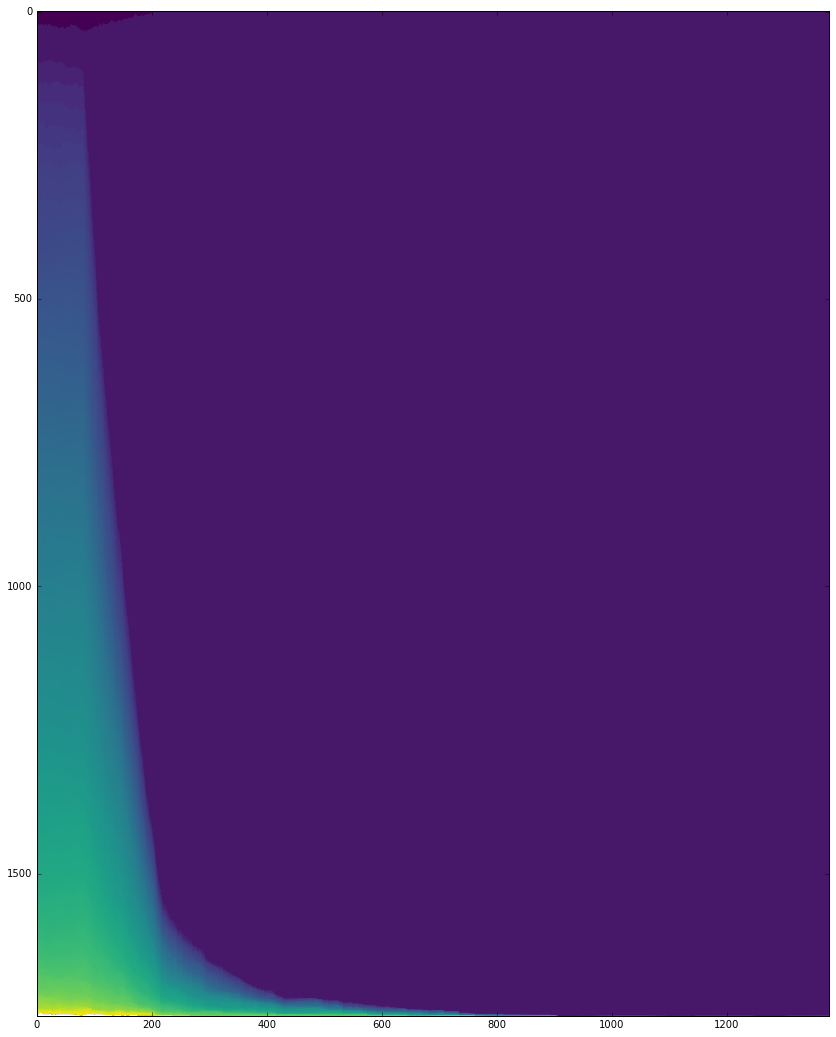

In [71]:
fig, ax = plt.subplots(figsize=(18,18))

d = (data['ACAGTG'] + data['ATCACG']) / 2.
d[d==0] = 1
d = np.log2(d)
d.sort(axis=0)
im = ax.imshow(d, cmap=cm.viridis)
plt.show()

In [72]:
ndata = {}
for barcode,factor in norm_factors.items():
    try:
        ndata[barcode] = data[barcode] * norm_factors[barcode] / norm_factors['CTTGTA']
    except KeyError:
        pass
    
d1 = (ndata['CGATGT'] + ndata['GCCAAT']) / 2.
d2 = (ndata['ACAGTG'] + ndata['ATCACG']) / 2.
d = d1 - d2
d[d==0] = 1
d[d>0] = np.log2(d[d>0])
d[d<0] = -1 * np.log2(-1 * d[d<0])
d.sort(axis=0)


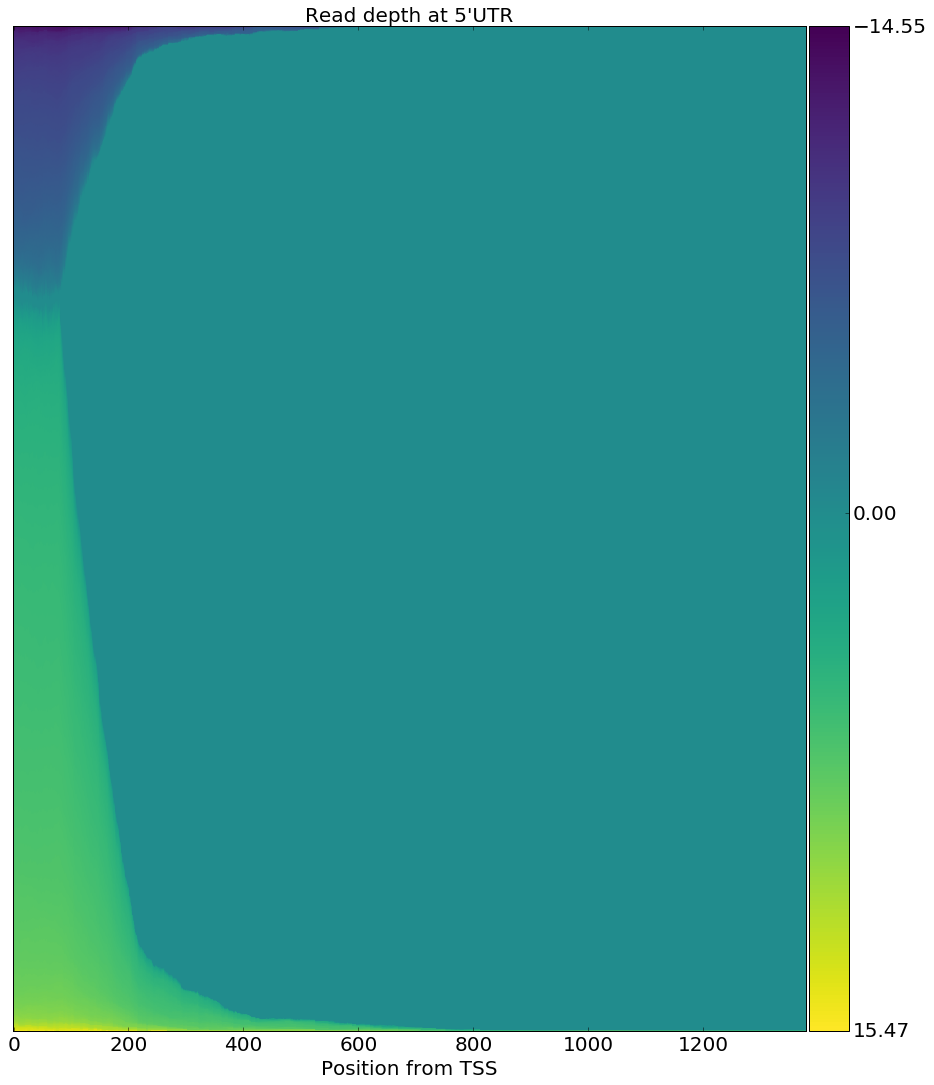

In [73]:
plot_utr_heatmap(d, cmap=cm.viridis)